<h1>Table of contents</h1>
 

<ul>
<li><a href="#1"><strong>1. Loading and preprocessing</strong></a>
</ul>
    
<ul>
<li><a href="#2"><strong>2. Load the Images with a generator and Data Augmentation</strong></a>
</ul>

<ul>
<li><a href="#3"><strong>3. Train the model</strong></a>
</ul>

<ul>
<li><a href="#4"><strong>4. Visualize the result</strong></a>
</ul>

<ul>
<li><a href="#5"><strong>5. Class activation heatmap for image classification</strong></a>
</ul>

# Context

This dataset contains images of the following food items:

- **fruits**: banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango
- **vegetables**: cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant

# Content
This dataset contains three folders:

- train (100 images each)
- test (10 images each)
- validation (10 images each)
each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present

# Note
This notebook is derived using elements the preprocessing steps found in https://www.kaggle.com/code/databeru/fruit-and-vegetable-classification and a derivation of the basic convolutional model as explained in the **Le Wagon** Data Science bootcamp challenges.


# 1. Loading and preprocessing<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [55]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

# Create a list with the filepaths for training and testing
train_dir = Path('../raw_data/fruits_and_vegetables_image_recognition_dataset/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg')) + list(train_dir.glob(r'**/*.jpeg')) + list(train_dir.glob(r'**/*.png'))

test_dir = Path('../raw_data/fruits_and_vegetables_image_recognition_dataset/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.jpeg')) + list(test_dir.glob(r'**/*.png'))

val_dir = Path('../raw_data/fruits_and_vegetables_image_recognition_dataset/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg')) + list(val_dir.glob(r'**/*.jpeg')) + list(val_dir.glob(r'**/*.png'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [56]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3040

Number of different labels: 36

Labels: ['peas' 'onion' 'kiwi' 'pomegranate' 'tomato' 'ginger' 'pineapple'
 'soy beans' 'cauliflower' 'turnip' 'paprika' 'beetroot' 'bell pepper'
 'spinach' 'lemon' 'eggplant' 'mango' 'potato' 'chilli pepper' 'capsicum'
 'garlic' 'carrot' 'radish' 'orange' 'cabbage' 'corn' 'grapes' 'banana'
 'sweetcorn' 'watermelon' 'jalepeno' 'cucumber' 'lettuce' 'pear'
 'sweet potato' 'apple']


In [57]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Filepath        Label
0  ../raw_data/fruits_and_vegetables_image_recogn...         peas
1  ../raw_data/fruits_and_vegetables_image_recogn...        onion
2  ../raw_data/fruits_and_vegetables_image_recogn...         kiwi
3  ../raw_data/fruits_and_vegetables_image_recogn...  pomegranate
4  ../raw_data/fruits_and_vegetables_image_recogn...       tomato

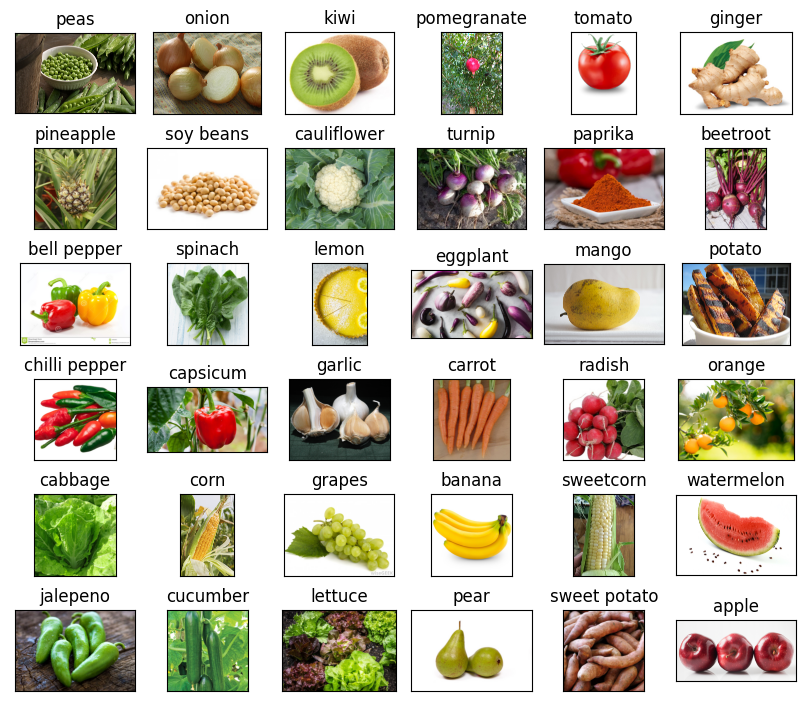

In [58]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# 2. Load the Images with a generator and Data Augmentation<a class="anchor" id="2"></a>

In [59]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3040 validated image filenames belonging to 36 classes.
Found 345 validated image filenames belonging to 36 classes.
Found 353 validated image filenames belonging to 36 classes.


In [60]:
test_images

In [61]:
# # Load the pretained model
# pretrained_model = tf.keras.applications.MobileNetV2(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet',
#     pooling='avg'
# )
# pretrained_model.trainable = False

# 3. Train the model<a class="anchor" id="3"></a>

In [62]:
# inputs = pretrained_model.input

# x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
# x = tf.keras.layers.Dense(128, activation='relu')(x)

# outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)

# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# history = model.fit(
#     train_images,
#     validation_data=val_images,
#     batch_size = 32,
#     epochs=5,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=2,
#             restore_best_weights=True
#         )
#     ]
# )

In [63]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

def load_own_model():

    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(224,224,3)))

    model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(2, padding='same'))
    
    model.add(layers.Conv2D(32, kernel_size=3, activation="relu", padding='same'))
    model.add(layers.MaxPooling2D(2, padding='same'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64, kernel_size=3, activation="relu", padding='same'))
    model.add(layers.MaxPooling2D(2, padding='same'))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(len(train_df.Label.unique()), activation='softmax'))
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

model_homemade = load_own_model()

In [64]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model_homemade.fit(train_images,
                             validation_data = val_images,
                             batch_size = 32, 
                             epochs = 100,  
                             callbacks=[es])

Epoch 1/100
10/95 [==>...........................] - ETA: 1:45 - loss: 3.5816 - accuracy: 0.0344

/Users/postboxes/.pyenv/versions/3.8.12/envs/whats_for_dinner/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


95/95 [==============================] - 139s 1s/step - loss: 3.4334 - accuracy: 0.0836 - val_loss: 3.5391 - val_accuracy: 0.0464
Epoch 2/100
95/95 [==============================] - 144s 2s/step - loss: 2.8613 - accuracy: 0.2220 - val_loss: 3.3297 - val_accuracy: 0.3101
Epoch 3/100
95/95 [==============================] - 141s 1s/step - loss: 2.5132 - accuracy: 0.3187 - val_loss: 2.9599 - val_accuracy: 0.4551
Epoch 4/100
95/95 [==============================] - 137s 1s/step - loss: 2.2789 - accuracy: 0.3836 - val_loss: 2.4981 - val_accuracy: 0.5913
Epoch 5/100
95/95 [==============================] - 139s 1s/step - loss: 2.0823 - accuracy: 0.4362 - val_loss: 2.1054 - val_accuracy: 0.5478
Epoch 6/100
95/95 [==============================] - 142s 1s/step - loss: 1.9079 - accuracy: 0.4924 - val_loss: 1.7050 - val_accuracy: 0.6116
Epoch 7/100
95/95 [==============================] - 138s 1s/step - loss: 1.7476 - accuracy: 0.5378 - val_loss: 1.4258 - val_accuracy: 0.6580
Epoch 8/100
95/95 

In [65]:
history.history

{'loss': [3.4333696365356445,
  2.8613078594207764,
  2.513165235519409,
  2.2788796424865723,
  2.082336187362671,
  1.9079428911209106,
  1.7475932836532593,
  1.569206953048706,
  1.4375818967819214,
  1.2599461078643799,
  1.122530460357666,
  0.9844628572463989,
  0.8521609902381897,
  0.7348670363426208,
  0.6190125942230225,
  0.527634859085083,
  0.4332340955734253,
  0.3572233021259308,
  0.2946840524673462,
  0.25403663516044617,
  0.20843501389026642,
  0.17182327806949615,
  0.14812421798706055,
  0.13215555250644684,
  0.1207817867398262],
 'accuracy': [0.08355262875556946,
  0.22203947603702545,
  0.3187499940395355,
  0.3835526406764984,
  0.43618419766426086,
  0.49243420362472534,
  0.5378289222717285,
  0.6006578803062439,
  0.6355262994766235,
  0.6996710300445557,
  0.7355263233184814,
  0.7799342274665833,
  0.8233552575111389,
  0.8546052575111389,
  0.8733552694320679,
  0.9075657725334167,
  0.9302631616592407,
  0.9523026347160339,
  0.9618421196937561,
  0.966

# 4. View history of training of the model

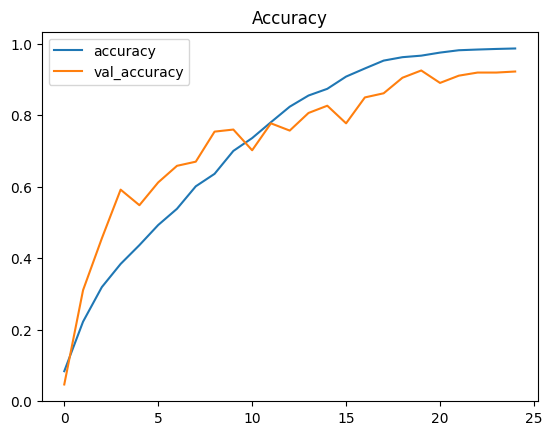

In [66]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")   
plt.show()

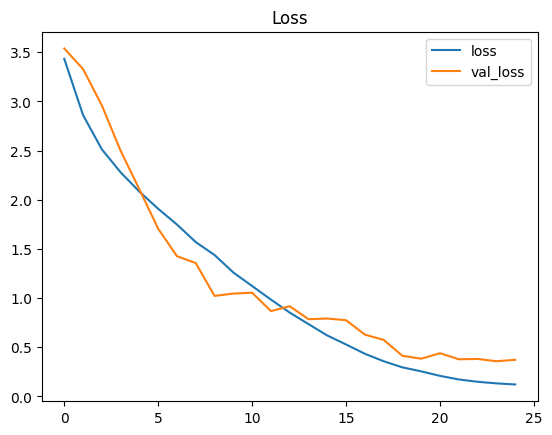

In [67]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# 5. Visualize the result on the test set

In [68]:
# Predict the label of the test_images
pred = model_homemade.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)

labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = [labels[k] for k in test_images.classes]


In [69]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 92.63%


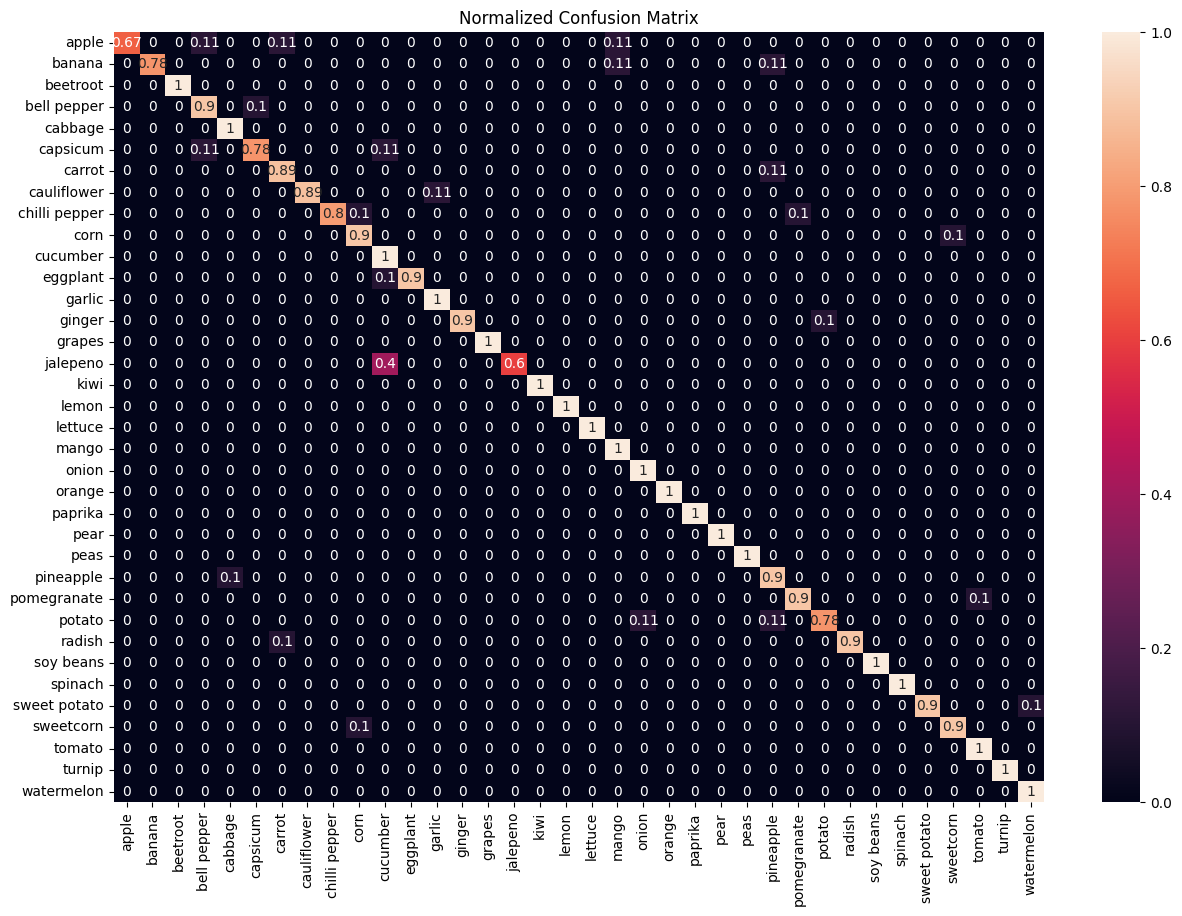

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

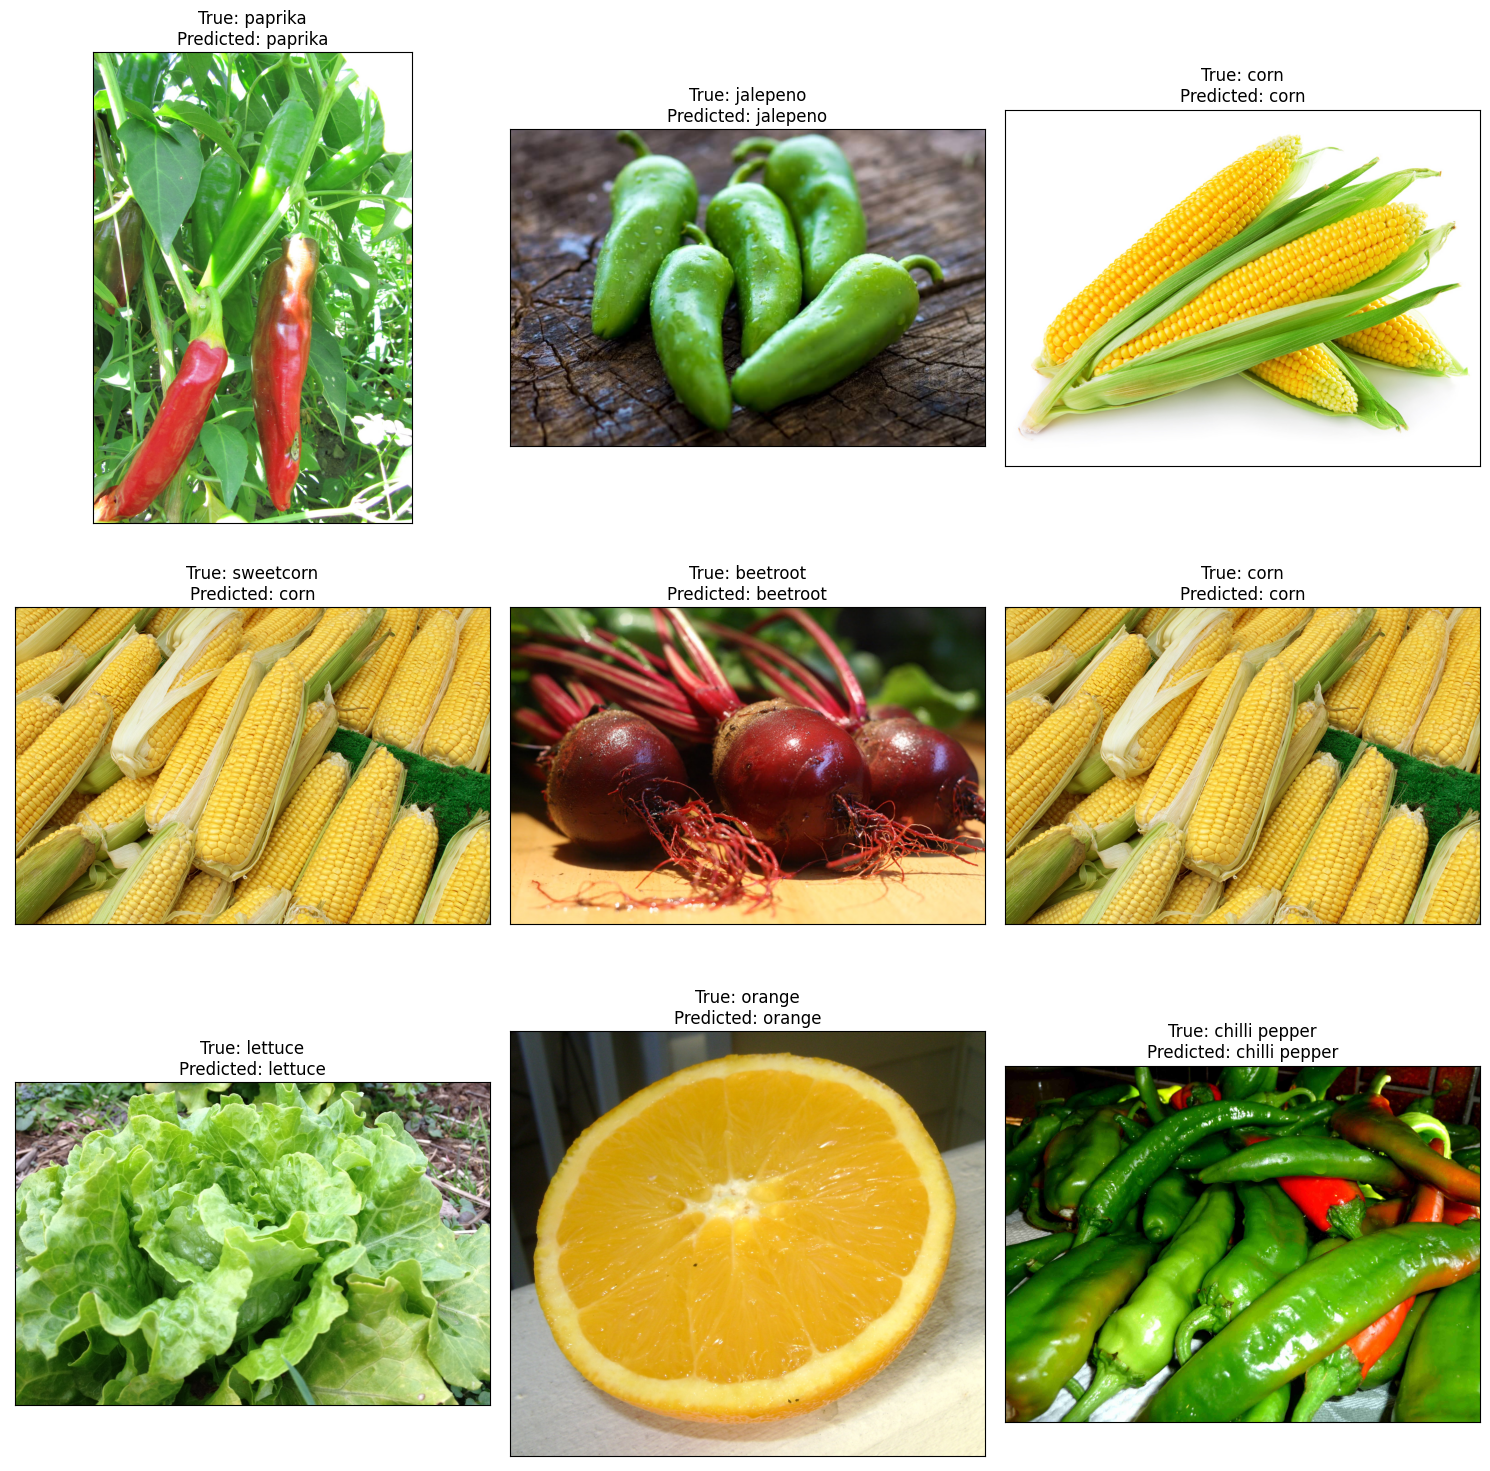

In [71]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# 6. Test the model on one image

In [72]:
# import cv2
# test_data = []
# test_img = cv2.imread('/Users/postboxes/code/hazmmmm/whats_for_dinner/raw_data/fruits_and_vegetables_image_recognition_dataset/train/lemon/Image_98.jpg')
# test_img = cv2.resize(test_img, (224,224))
# test_data.append(test_img)
# test_data = np.array(test_data, dtype="float")
# final_test_img = test_generator.flow(test_data, 
#                                      batch_size=1,
#                                      )

In [73]:
# predicted_probabilities = model_homemade.predict(final_test_img)
# predicted_probabilities.shape
# predicted_class = predicted_probabilities.argmax()
# predicted_class
# class_names = sorted(train_df['Label'].unique())
# final_pred_class = class_names[predicted_class]
# final_pred_class

In [74]:
# Create a list with the filepaths for prediction
pred_dir = Path('../raw_data/fruits_and_vegetables_image_recognition_dataset/pred')
pred_filepaths = list(pred_dir.glob(r'*.jpg')) + list(pred_dir.glob(r'*.jpeg')) + list(pred_dir.glob(r'*.png'))
pred_filepaths

[PosixPath('../raw_data/fruits_and_vegetables_image_recognition_dataset/pred/01.jpg'),
 PosixPath('../raw_data/fruits_and_vegetables_image_recognition_dataset/pred/05.jpg'),
 PosixPath('../raw_data/fruits_and_vegetables_image_recognition_dataset/pred/04.jpg'),
 PosixPath('../raw_data/fruits_and_vegetables_image_recognition_dataset/pred/Image_96.jpg')]

In [75]:
pred_df = proc_img(pred_filepaths)
pred_df

Filepath Label
0  ../raw_data/fruits_and_vegetables_image_recogn...  pred
1  ../raw_data/fruits_and_vegetables_image_recogn...  pred
2  ../raw_data/fruits_and_vegetables_image_recogn...  pred
3  ../raw_data/fruits_and_vegetables_image_recogn...  pred

In [76]:
pred_img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

pred_images = pred_img_generator.flow_from_dataframe(
    dataframe=pred_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4 validated image filenames belonging to 1 classes.


In [77]:
# predicted_probabilities = model_homemade.predict(pred_images)
# predicted_class = predicted_probabilities.argmax()
# predicted_class
# class_names = sorted(train_df['Label'].unique())
# final_pred_class = class_names[predicted_class]
# final_pred_class

predicted_probabilities = model_homemade.predict(pred_images)
predicted_probabilities = np.argmax(predicted_probabilities,axis=1)
predicted_probabilities
predicted_probabilities = [labels[k] for k in predicted_probabilities]
predicted_probabilities

['lemon', 'apple', 'cucumber', 'apple']

# 7. Evaluate the model on extra data 


In [78]:
eval_dir = Path('../raw_data/fruits_and_vegetables_image_recognition_dataset/eval')
eval_filepaths = list(eval_dir.glob(r'**/*.jpg')) + list(eval_dir.glob(r'*.jpeg')) + list(eval_dir.glob(r'*.png'))
eval_df = proc_img(eval_filepaths)
eval_df

Filepath       Label
0    ../raw_data/fruits_and_vegetables_image_recogn...        peas
1    ../raw_data/fruits_and_vegetables_image_recogn...   sweetcorn
2    ../raw_data/fruits_and_vegetables_image_recogn...  watermelon
3    ../raw_data/fruits_and_vegetables_image_recogn...      grapes
4    ../raw_data/fruits_and_vegetables_image_recogn...      turnip
..                                                 ...         ...
113  ../raw_data/fruits_and_vegetables_image_recogn...   sweetcorn
114  ../raw_data/fruits_and_vegetables_image_recogn...      orange
115  ../raw_data/fruits_and_vegetables_image_recogn...       mango
116  ../raw_data/fruits_and_vegetables_image_recogn...     paprika
117  ../raw_data/fruits_and_vegetables_image_recogn...    cucumber

[118 rows x 2 columns]

In [79]:
eval_images = test_generator.flow_from_dataframe(
    dataframe=eval_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 118 validated image filenames belonging to 36 classes.


In [80]:
# Predict the label of the eval_images
pred = model_homemade.predict(eval_images)
pred = np.argmax(pred,axis=1)

# Map the label
pred = [labels[k] for k in pred]
y_test = [labels[k] for k in eval_images.classes]

acc = accuracy_score(y_test, pred)
print(f'Accuracy on the eval set: {100*acc:.2f}%')

Accuracy on the eval set: 94.07%


In [81]:
pred = model_homemade.evaluate(eval_images)

4/4 [==============================] - 5s 1s/step - loss: 0.3709 - accuracy: 0.9407
